# Tuturial 1: Creating and Solving Factor Graphs
In this tutorial you will lear the basics of factor graphs and consepts such as variables, factors, priors and how create solve and explore them.

## What is a Factor Graph

Wikipedia tels us a factor graph is a bipartite graph representing the factorization of a function.
 
If you haven't taken some advanced statistics classes you are probably wondering, bipartite graph?, factorization?, I just want to navigate my robot.
For robotics, factor graphs are the common language used to describe your robot's estimation problem (the function) in a way both humans and computers can understand. 
The estimation problem can be anything from robot localization, structure from motion, calibration to full PoseSLAM with parametric or non-parametric measurements and beliefs.
A factor graph is a graphical model with two types of nodes, variables and factors, connected by edges between the variables and factors (bipartite graph). 
Variables represent the unknown random variables in the estimation problem, such as vehicle or landmark positions, sensor calibration parameters, and more.
Factors represent the algebraic interaction between particular variables, such as wheel odometry, which is captured through edges. 
Breaking down the complex system describing your robot to a graph of variables and factors is the factorization of the function decribing your system, such as the position and orientation (pose) of your robot at any given time. 
This factorisation allows us to solve the optimization problem for every variable given every measurement described by the factors.
See Caesar.jl docs [Graph Concepts](https://juliarobotics.org/Caesar.jl/latest/concepts/concepts/#Graph-Concepts) for more detail.

### Lets build a factor graph

First we will need some packages: 
- `NavAbilitySDK` - for interacting with the graph.
- `numpy` - for matrices and calculations.
- `Plotly` - for visualizing graphs [TODO].


In [10]:
from navability.entities import *
from navability.services import *
from uuid import uuid4
import asyncio
import numpy as np

To create a new factor graph with default settings create a new NavAbility client and a client that indicates the user, robot, and session. 

In [18]:
# Start with an empty factor graph
navability_client = NavAbilityHttpsClient()
client = Client("Guest", "PySDKAutomation", "Session_" + str(uuid4())[0:8])
print(client)

<Client(userId=Guest, robotId=PySDKAutomation, sessionId=Session_1c4aa3f2)>


## Variable and Factors 

Variables, denoted as the larger nodes in the figure below, represent state variables of interest such as vehicle or landmark positions, sensor calibration parameters, and more. Variables are likely hidden values which are not directly observed, but we want to estimate them from observed data and at least some minimal algebra structure from probabilistic measurement models.

Factors, the smaller nodes in the figure below, represent the algebraic interaction between particular variables, which is captured through edges. Factors must adhere to the limits of probabilistic models – for example conditional likelihoods capture the likelihood correlations between variables; while priors (unary to one variable) represent absolute information to be introduced. 

We start with a `Pose2` variable, i.e. position and orientation in two dimensions.
To add variables to our factor graph e created above, call `addVariable` with a label `x0` and type `Pose2`


In [19]:
v = Variable("x0", VariableType.Pose2.value)
result_id = await addVariable(navability_client, client, v)
print(f"Added {v.label} with result ID {result_id}")
# Wait for it to be loaded.
await waitForCompletion(navability_client, [result_id])

/tmp/ipykernel_717577/614610570.py:2: RuntimeWarning: coroutine 'addFactor' was never awaited
  result_id = await addVariable(navability_client, client, v)


Added x0 with result ID 01FY4Q8F9G6BNVMWZ2WSW31TXT


We now have a factor graph with one variable, but to solve it we need some additional information. 
In this example we need the estimated starting point of our robot.
We use unary factors called priors to represent absolute information to be introduced.
This unary factor is taken as a matrix `FullNormal` distribution with zero mean and a covariance matrix of `diagm([0.5,0.5,0.1].^2)`.


In [20]:
prior_distribution = FullNormal(mu=np.zeros(3), cov=np.power(np.diag([0.1, 0.1, 0.1]),2))
prior_factor = Factor("x0f1", "PriorPose2", ["x0"], FactorData(fnc=PriorPose2(Z=prior_distribution).dump()))
result_id = await addFactor(navability_client, client, prior_factor) 
print(f"Added {v.label} with result ID {result_id}")
# Wait for it to be loaded.
await waitForCompletion(navability_client, [result_id])

Added x0 with result ID 01FY4Q9XCFESWGF9G10X3VJ5E4


Lets have a look at the factor graph we have so far using `plotDFG`.

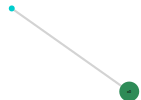

In [7]:
# TODO
# plotDFG(fg)

The prior is now connected to the variable, `x0`, but it is not initialized yet. Automatic initialization of variables depend on how the factor graph model is constructed. This tutorial demonstrates this behavior by first showing that :x0 is not initialized:

In [8]:
# isInitialized(fg, :x0)

false

Why is `:x0` not initialized? Since no other variable nodes have been 'connected to' (or depend) on `:x0` and future intentions of the user are unknown, the initialization of `:x0` is deferred until the latest possible moment. `IncrementalInference.jl` assumes that the user will generally populate new variable nodes with most of the associated factors before moving to the next variable. By delaying initialization of a new variable (say `:x0`) until a second newer uninitialized variable (say `:x1`) depends on `:x0`, the IncrementalInference algorithms hope to then initialize `:x0` with the more information from previous and surrounding variables and factors. Also note that initialization of variables is a local operation based only on the neighboring nodes – global inference over the entire graph is shows later in this tutorial.

Lets look as a odometry factor that connects our two robot poses `x0` and `x1`. Since factors represents a probabilistic interaction between variables we need to specify the distribution our factor will represent. Here we use `MvNormal` which is a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) from [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) to represent the odometry with (x=1.0,y=0.0,θ=pi/2) and diagonal elements of the covariance diagm([0.1, 0.1, 0.01].^2)

In [21]:
v = Variable("x1", VariableType.Pose2.value)
result_v = await addVariable(navability_client, client, v)
print(f"Added {v.label} with result ID {result_v}")
odo_distribution = FullNormal(mu=[1.0, 0.0, np.pi/2], cov=np.power(np.diag([0.1, 0.1, 0.01]),2))
fac_1 = Factor("x0x1f1", "Pose2Pose2", ["x0", "x1"], FactorData(fnc=Pose2Pose2(Z=prior_distribution).dump()))
result_fac_1 = await addFactor(navability_client, client, prior_factor) 
print(f"Added {fac_1.label} with result ID {result_fac_1}")

# Wait for it to be loaded.
await waitForCompletion(navability_client, [result_v, result_fac_1])

Added x1 with result ID 01FY4Q9XCFESWGF9G10X3VJ5E4


By adding `x1` and connecting it with a factor to `x0` the automatic initialization of `x0` is triggered. 
Note that the automatic initialization of :x0 is aware that :x1 is not initialized and therefore only used the Prior unary factor to initialize the marginal belief estimate for `x0`. The structure of the graph has now been updated to two variable nodes and two factors.

In [10]:
# isInitialized(fg, :x0)

true

### Solving

We now have a graph we can solve. 

In [27]:
solve_request = await solveSession(navability_client, client)
# Wait for it to be loaded.
await waitForCompletion(navability_client, [solve_request])

### Results

The RoMEPlotting.jl package allows visualization (plotting) of the belief state over any of the variable nodes.

In [32]:
# import plotly

[0.113 0.035; 0.035 0.134]
[0.107 -0.01; -0.01 0.152]


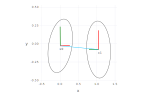

In [19]:
#pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawhist=false, drawPoints=false)

What is happening
The figure shows the position and orientation (red forward) for poses `x0` and `x1`. As well as the covarance ellipse. 
A few other functoins are also handy for interacting with the factor graph, for instance `getVariable` returns the full variable.
Or if you are interested in the suggested Parametric Point Estimate (PPE) you can get this from the PPE data.

In [28]:
var = await getVariable(navability_client, client, "x1")
print(var)

<Variable(label=x1,variableType=RoME.Pose2,tags=['VARIABLE'])>


In [29]:
var.ppes
#getPPESuggested(fg, :x1)

{}

`getPPESuggested(fg, :x1)` returns the parametric point estimate for the current belief in variable `x1`.
A PPE can be the maximum or mean of the belief. If the belief is a normal distribution both corresponds with its mean. 
However, care should be taken with using PPEs when beliefs might be non-parametric, for example, in a multimodal beliefs with two peaks, max corresponds with the maximum of the two peaks with a mean that will fall somewhere in between them. 
In non-parametric cases it is better to work with the full belief obtained by the Kernel Density Estimate (KDE).  
Kernel Density Estimation is a non-parametric way to estimate the probability density function of a random variable.
With the default solver a full probability density function is always available and can be visualized using `plotKDE`.
Mon-parametric solves will be discussed in more detail in tutorial 2. We only show the plot for variable `x1` here.




In [31]:
# plotKDE(fg, :x1)

In [30]:
# plotPose(fg, :x0)

See the [section on Plotting in the Caesar docs](https://juliarobotics.org/Caesar.jl/latest/concepts/2d_plotting/) for more detail.

### Adding more poses and a point landmark

`#TODO to close the loop`

In [33]:

variables = [
  Variable("l1", VariableType.Point2.value),
  Variable("x2", VariableType.Pose2.value),
  Variable("x3", VariableType.Pose2.value),
  Variable("x4", VariableType.Pose2.value)]
results_variables = [await addVariable(navability_client, client, v) for v in variables]

factors = [
  # TODO
  # Factor("x0l1f2", "Pose2Point2BearingRange", ["x0", "x1"], 
  #     FactorData(fnc=Pose2Point2BearingRange(Normal(0.0,0.03), Normal(0.5,0.1)).dump())),
  Factor("x2x3f1", "Pose2Pose2", ["x2", "x3"], 
      FactorData(fnc=Pose2Pose2(odo_distribution).dump())),
  Factor("x3x43f1", "Pose2Pose2", ["x3", "x4"], 
      FactorData(fnc=Pose2Pose2(odo_distribution).dump())),
]
results_factors = [await addFactor(navability_client, client, f) for f in factors]
await waitForCompletion(navability_client, results_variables + results_factors)

ClientConnectionError: Connection closed

[ Info: try doautoinit! of x4


DFGFactor{CommonConvWrapper{Pose2Pose2...}}
  timestamp:     2022-02-26T22:00:44.789+02:00
   nstime:       0 nanoseconds
  label:         x3x4f1
  solvable:      1
  VariableOrder: [:x3, :x4]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: Pose2Pose2{FullNormal}
Z:
FullNormal(
dim: 3
μ: [1.0, 0.0, 1.5708]
Σ: [0.01 0.0 0.0; 0.0 0.01 0.0; 0.0 0.0 0.0001]
)



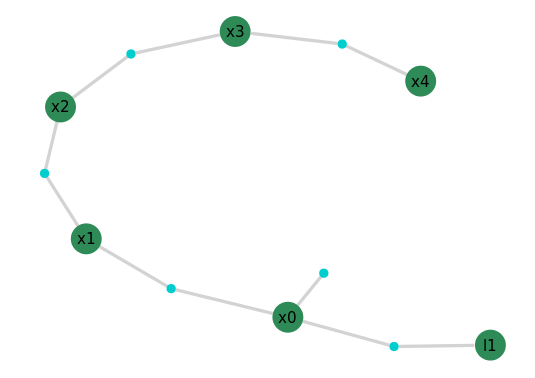

In [28]:
# plotDFG(fg)

In [34]:
solve_request = await solveSession(navability_client, client)
# Wait for it to be loaded.
await waitForCompletion(navability_client, [solve_request])

TransportAlreadyConnected: Transport is already connected

[0.033 -0.003; -0.003 0.043]
[0.031 0.0; 0.0 0.024]
[0.025 0.004; 0.004 0.041]
[0.03 0.001; 0.001 0.061]
[0.027 0.005; 0.005 0.034]
[0.046 -0.003; -0.003 0.041]


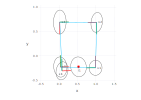

In [31]:
#pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawhist=false, drawPoints=false)

In [30]:
p2br = Factor("x4l1f2", "Pose2Point2BearingRange", ["x0", "x1"], 
          FactorData(fnc=Pose2Point2BearingRange(Normal(0.0,0.03), Normal(0.5,0.1)).dump())),
result_factor = await addFactor(navability_client, client, p2br)
await waitForCompletion(navability_client, client, [result_factor])

[ Info: try doautoinit! of x4
[ Info: init with useinitfct [:x3x4f1, :x4l1f1]
[ Info: do init of x4


DFGFactor{CommonConvWrapper{Pose2Point2BearingRange...}}
  timestamp:     2022-02-26T22:01:19.547+02:00
   nstime:       0 nanoseconds
  label:         x4l1f1
  solvable:      1
  VariableOrder: [:x4, :l1]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: Pose2Point2BearingRange{Normal{Float64}, Normal{Float64}}
bearing:
Normal{Float64}(μ=0.0, σ=0.03)
range:
Normal{Float64}(μ=0.5, σ=0.1)


┌ Info: Ensure variables are all initialized (graphinit)
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/SolverAPI.jl:301
┌ Info: Solving over the Bayes (Junction) tree.
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/SolverAPI.jl:309
┌ Info: Bayes Tree Complete
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/JunctionTree.jl:797
┌ Info: Do tree based init-ference
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/SolverAPI.jl:343
Solve Progress: approx max 96, at iter 13 	 Time: 0:00:05

Solve Progress: approx max 96, at iter 17 	 Time: 0:00:08

Solve Progress: approx max 96, at iter 27 	 Time: 0:00:16

┌ Info: CSM-5 Clique 2 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/CliqueStateMachine.jl:804
Solve Progress: approx max 96, at iter 35 	 Time: 0:00:17Solve Progress: approx max 96, at iter 36 	 Time: 0:00:17Solve Progress: approx max 96, at iter 37 	 Time: 0:00:17Solve Progress: approx max 96, at iter 38 	 Time: 0:00:17

┌ Info: CSM-5 Clique 3 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/CliqueStateMachine.jl:804
┌ Info: CSM-5 Clique 4 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/CliqueStateMachine.jl:804
┌ Info: CSM-5 Clique 1 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/CliqueStateMachine.jl:804
Solve Progress: approx max 96, at iter 47 	 Time: 0:00:18


Building Bayes net...
Find potential functions for each clique
[0.03 -0.015; -0.015 0.04]
[0.023 -0.005; -0.005 0.022]
[0.019 -0.001; -0.001 0.023]
[0.01 -0.0; -0.0 0.017]
[0.019 0.003; 0.003 0.026]
[0.014 -0.002; -0.002 0.016]


┌ Info: Finished tree based init-ference
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/El6vc/src/SolverAPI.jl:363


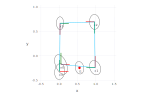

In [33]:
solve_request = await solveSession(navability_client, client)
# Wait for it to be loaded.
await waitForCompletion(navability_client, [solve_request])

#pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawhist=false, drawPoints=false)

#TODO solve on cloud
#TODO also do parametric?
#TODO show the bayes tree and give a basic introduction on the solver?